In [17]:
import os, glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage import color
from PIL import Image

In [3]:
#note: file is stored in main directory, accessing files in ./data/
DATASET_FOLDER = "./data"
path_csv = os.path.join(DATASET_FOLDER, "train.csv")
df_train = pd.read_csv(path_csv)
display(df_train.head())

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female


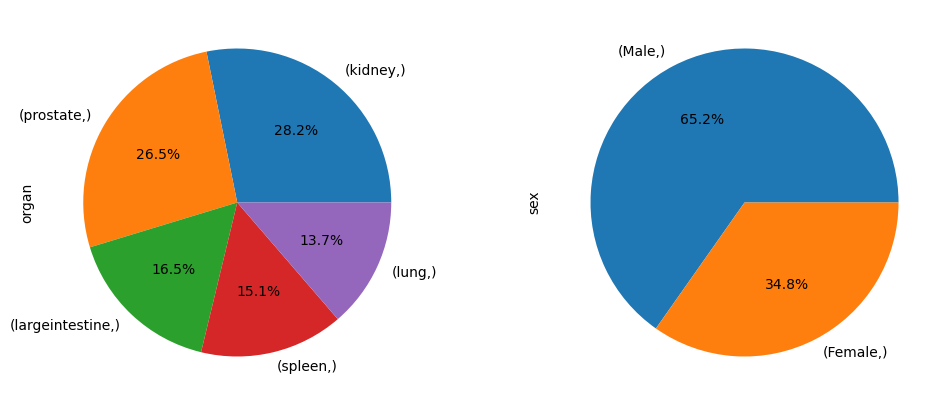

In [4]:
#EXPLORE METADATA
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
for i, col in enumerate(["organ", "sex"]):
    _= df_train[[col]].value_counts().plot.pie(ax=axes[i], autopct='%1.1f%%', ylabel=col)

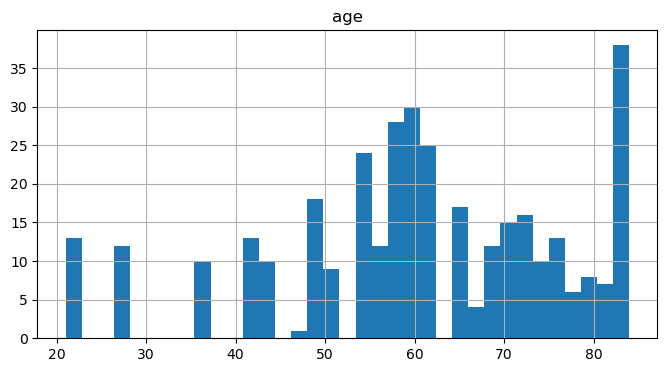

In [6]:
_= df_train[["age"]].hist(bins=35, figsize=(8, 4))

In [7]:
#IMAGE SIZE HISTOGRAMS
for _, row in df_train.iterrows():
    if row["img_height"] != row["img_width"]:
        print(dict(row))
df_train["img_size"] = df_train["img_width"]

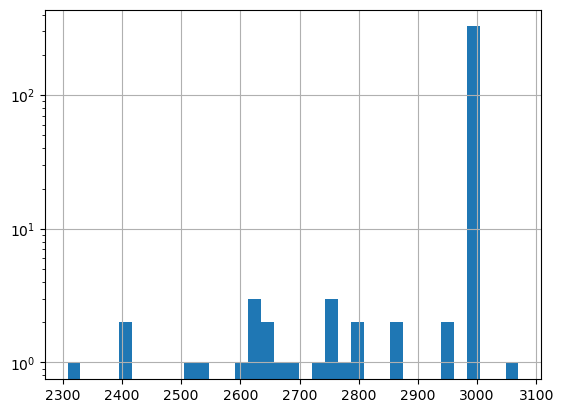

In [10]:
ax = df_train["img_size"].hist(bins=35)
ax.set_yscale('log')

In [14]:
#PARKER'S HELPERS
def EncodeRLE(arr):
    # Flatten array column wise
    flat = arr.ravel('F') # column-wise
    switches = np.nonzero(np.append(flat,0) - np.append(0,flat))[0]
    counts = np.append(switches,switches[-1]) - np.append(0,switches)

    counts = counts[:-1]
    rle = np.hstack((switches[::2][:,None],counts[1::2][:,None]))
    
    return rle.ravel()

def DecodeRLE(rle_arr,img_shape):
    mask = np.zeros(img_shape).ravel()
    for row in range(len(rle_arr)):
        start, count = rle_arr[row,0], rle_arr[row,1]
        mask[start:start+count] = 1
    
    mask = mask.reshape(img_shape)
    return mask.T

In [36]:
from kaggle_imsegm.mask import rle_encode
#kaggle helper: rle_decode() + encode()
#! pip install https://github.com/Borda/kaggle_image-segm/archive/refs/heads/main.zip

def rle_decode(mask_rle: str, img_shape: tuple = None) -> np.ndarray:
    seq = mask_rle.split()
    starts = np.array(list(map(int, seq[0::2])))
    lengths = np.array(list(map(int, seq[1::2])))
    assert len(starts) == len(lengths)
    ends = starts + lengths
    img = np.zeros((np.product(img_shape),), dtype=np.uint8)
    for begin, end in zip(starts, ends):
        img[begin:end] = 1
    # https://stackoverflow.com/a/46574906/4521646
    img.shape = img_shape
    return img

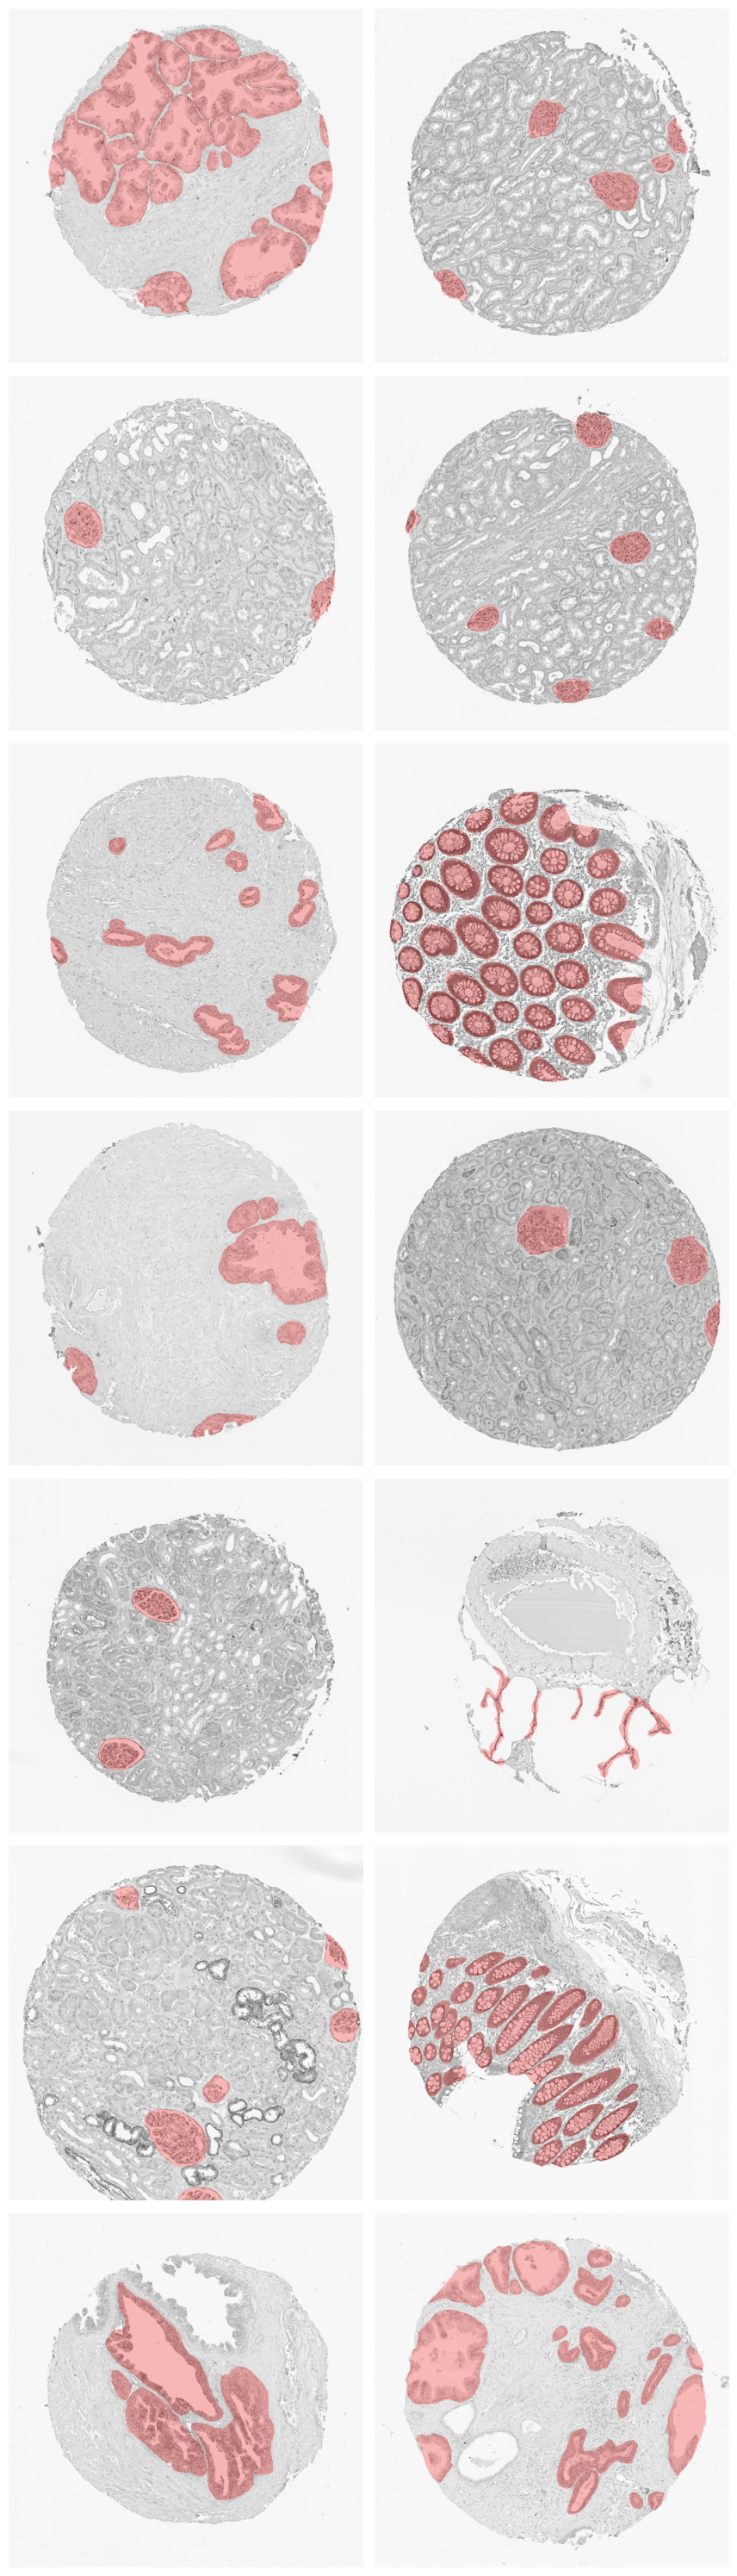

In [38]:
#SHOW IMAGES + MASKS
#TODO: MAKE THIS WORK WITH PARKER'S FUNCTIONS
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(9, 30))
for i, (_, row) in enumerate(df_train.sample(14).iterrows()):
    img = plt.imread(os.path.join(DATASET_FOLDER, "train_images", f"{row['id']}.tiff"))
    mask = rle_decode(row['rle'], img_shape=(row["img_height"], row["img_width"])).T
    axes[i // 2, i % 2].imshow(color.label2rgb(mask, img, bg_label=0, bg_color=(1.,1.,1.), alpha=0.25))
    axes[i // 2, i % 2].set_axis_off()
    rle = rle_encode(mask.T)
    assert row['rle'] == rle[1]
fig.tight_layout()
